In [24]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [25]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [26]:
### --- Set empirical parameters --- ###

#network properties size
N = 2000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)

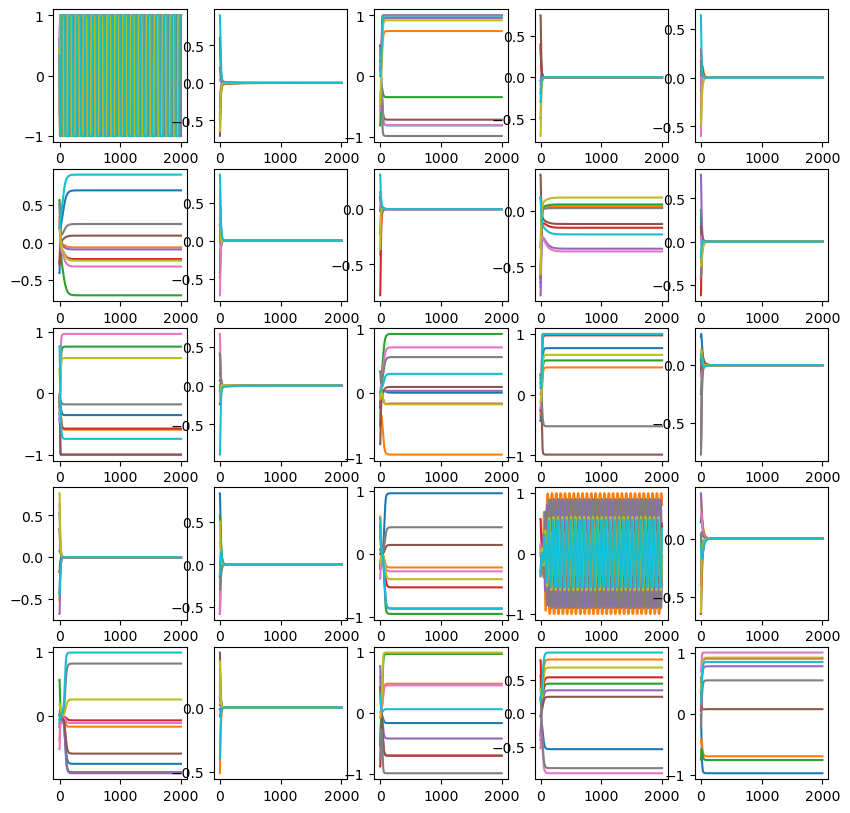

In [66]:
#Network size
N = 2000
R = 2
sigma_sigma = 0.2
s = 5
W = 0
N_tasks = 500
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
N_show = 25
all_loadings = np.zeros((N_tasks, N, 2*R))
n_x = int(np.ceil(np.sqrt(N_show)))
fig, ax = plt.subplots(n_x, n_x, figsize=(10, 10))
ax = ax.flatten()
for i_task in range(N_tasks):
    sigma_mm = np.eye(R)
    sigma_nn = 10*np.eye(R)
    if i_task > 0:
        sigma_mn = np.random.normal(0, sigma_sigma, (R, R))
    else:
        sigma_diag = 1.6
        sigma_off = 0.8
        sigma_mn = 1.5*np.array([[sigma_diag, -sigma_off],
                             [sigma_off, sigma_diag]])
    covariance_top = np.hstack([sigma_mm, sigma_mn])
    covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
    covariance = np.vstack([covariance_top, covariance_bot])

    loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
    all_loadings[i_task] = loadings
    W_task = s*D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])/ N
    W += W_task
    W_task_ = torch.from_numpy(W_task).type(torch.FloatTensor).to(0)
    if i_task//2 < N_show and i_task%2==0:
        x, r = sample_activity(T_sim=200, dt_save=0.1, dt=0.1, W=W_task_, phi_torch=phi_torch,
                           T_save_delay=0, N_batch=1, runga_kutta=True, noise_sigma=0)
        ax[i_task//2].plot(r[:,:10])
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)

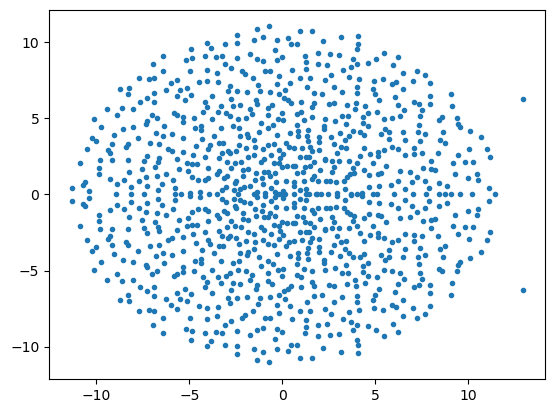

In [67]:
eigs, vecs = np.linalg.eig(W)
plt.plot(eigs.real, eigs.imag, '.')

In [68]:
W_.cpu().detach().numpy().std()*np.sqrt(N)

11.170975632064726

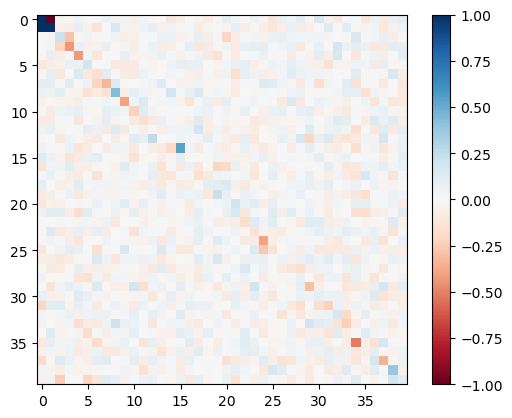

In [69]:
n_tasks_show = 20
overlaps = np.einsum('air, bis -> arbs', all_loadings[:n_tasks_show,:,:R], all_loadings[:n_tasks_show,:,R:])/N
plt.imshow(overlaps.reshape(n_tasks_show*R, n_tasks_show*R, order='C'), vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()

In [70]:
#i_task = 0
#m1 = all_loadings[i_task,:,0]
#m1 = torch.from_numpy(m1).type(torch.FloatTensor).to(0)
x, r = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       T_save_delay=100, N_batch=1, runga_kutta=True, noise_sigma=0, input_current=None)

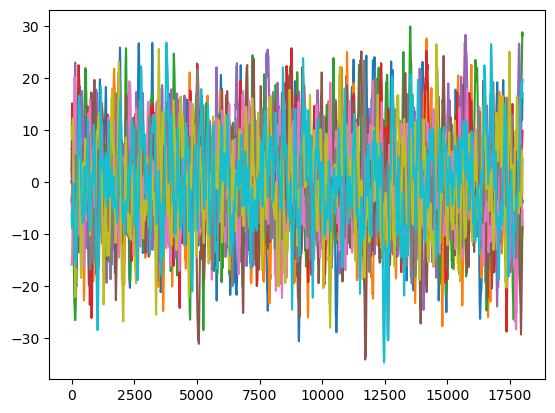

In [71]:
for i in range(10):
    plt.plot(x[:,i])

In [72]:
Z = np.einsum('air, ti -> atr', all_loadings[:20, :, 2:4], r)

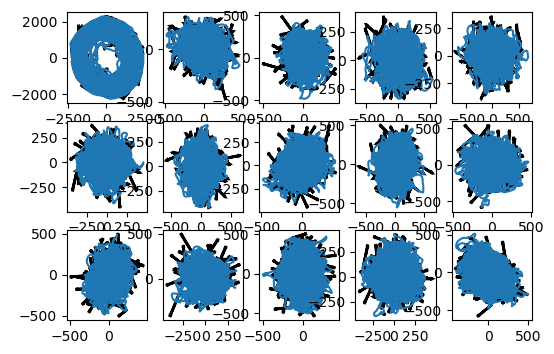

In [73]:
ccw_scores = []
fig, ax = plt.subplots(3, 5, figsize=(6, 4))
ax = ax.flatten()
for i_task in range(15): 
    x = Z[i_task,:,0]
    y = Z[i_task,:,1]
    ax[i_task].plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    for i in range(0, len(x) - skip, skip):
        ax[i_task].arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
                  shape='full', lw=2, length_includes_head=False, head_width=3)
    

In [19]:
ccw_scores = []
for i_task in range(20): 
    x = Z[i_task,:,0]
    y = Z[i_task,:,1]
    #plt.plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    #for i in range(0, len(x) - skip, skip):
    #    plt.arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
    #              shape='full', lw=2, length_includes_head=False, head_width=3)
    v_x = x[1:] - x[:-1]
    v_y = y[1:] - y[:-1]
    #plt.figure()
    ccw_scores.append(np.array([(-v_x * y[1:]).mean(), (v_y * x[1:]).mean()]))
    #plt.hist(-v_x * y[1:], bins=100)
    #plt.hist(v_y * x[1:], bins=100)

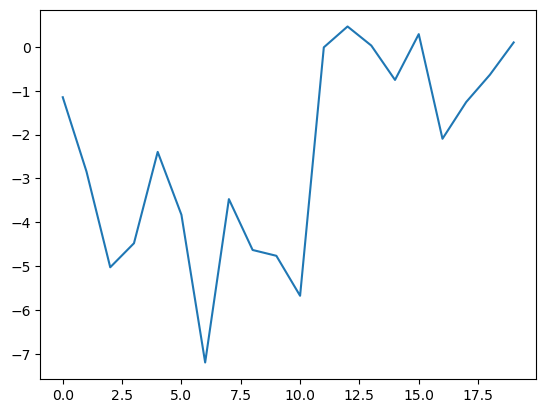

In [20]:
ccw_scores = np.array(ccw_scores)
plt.plot(ccw_scores[:,1])

In [ ]:
v_x = x[1:] - x[:-1]
v_y = y[1:] - y[:-1]
plt.hist(-v_x * y[1:], bins=100)
plt.hist(v_y * x[1:], bins=100)

In [ ]:
x_fft = np.fft.rfft(x[:,:10], axis=0)
freq = np.fft.rfftfreq(x.shape[0], d=0.05)
plt.plot(freq, np.abs(x_fft)**2)
plt.xlim([0, 1])

In [ ]:
from scipy.spatial import distance_matrix
dist_matrix = distance_matrix(r[:, :2000], r[:, :2000])
i, j = np.triu_indices(dist_matrix.shape[0])
D = dist_matrix[i, j]
plt.hist(D, bins=1000)
plt.yscale('log')

In [ ]:
plt.imshow(dist_matrix[:500,:500])

In [ ]:
### --- Estimate psi empirically --- ###

compute_empirical_psi = (mode == 'sim')
if compute_empirical_psi:
    W_ = W
    x_cov, r_cov = estimate_cov_eigs(T_sim=2000, dt_save=1, dt=0.05, W=W_, phi_torch=phi_torch,
                                     T_save_delay=1000, N_batch=1, N_loops=50,
                                     return_raw_covs=True, runga_kutta=True)
    
    dim_emp = np.trace(r_cov)**2 / (r_cov**2).sum() / N
else:
    dim_emp = 0

In [ ]:
### --- Set theory parameters --- ###
T_window = 200
dT = 0.025

In [ ]:
### --- Compute single-unit properties
d = compute_Delta_0(g=g)
time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
Delta_T = fix(Delta_T)
C_phi_half = compute_C_simple(d, Delta_T)
avg_gain = compute_phi_prime_avg(d)

In [ ]:
### --- Compute Psi from theory --- ###

#Define relevant single-unit functions
C_phi = np.concatenate([C_phi_half,
                        np.array([C_phi_half[-1]]),
                        C_phi_half[1:][::-1]])
C_phi_omega = fft(C_phi, dT)
T = len(C_phi)
t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
sampfreq = 1/dT
w = 2*np.pi*sampfreq*t_indices/T
C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
S_phi_S_phi = np.multiply.outer(S_phi, S_phi)


#Compute psi of normalized units for LDRG network
num = 1 + (1/(alpha*PR_D) + 1/PR_G - 1)*np.abs(2*np.pi*g**2 * S_phi_S_phi)**2
denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)

In [ ]:
C2 = C_phi_half[0]**2
dim_theory = C2/(C2 + Psi_tau1_tau2[0,0].real)

In [ ]:
processed_data = np.array([dim_emp, dim_theory])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'LDRG_PR_match_PRD'
job_name = 'LDRG_PR_match_PRD_theory_final'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name),
               mem=64, n_hours=24, n_gpus=1,
               results_subdir='PRL_Submission')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False, results_subdir='PRL_Submission')

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'LDRG_PR_match_PRD_theory_final'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
job_name = 'LDRG_PR_match_PRD_sim_final'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
### --- Save packaged results --- ###
with open('packaged_results/LDRG_PR_match_PRD_theory_final', 'wb') as f:
    pickle.dump(theory_results, f)
    
with open('packaged_results/LDRG_PR_match_PRD_sim_final', 'wb') as f:
    pickle.dump(sim_results, f)

In [ ]:
!ls packaged_results/

In [ ]:
sim_results

In [ ]:
for i_g, g in enumerate(sim_results[0]['g']):
    plt.figure(figsize=(4, 4))
    for k in range(10):
        pass
        plt.plot(sim_results[0]['PR_D'], sim_results[1][:,i_g,k,0], '.', color='C0', alpha=0.1)
    plt.plot(sim_results[0]['PR_D'], sim_results[1][:,i_g,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
    plt.plot(theory_results[0]['PR_D'], theory_results[1][:,i_g,0,1], color='k')
    plt.axhline(y=iid_dim_theory[i_g], color='k', linestyle='--')
    plt.ylim([0, 0.12])
    #plt.xlim([0, 1])
    plt.xscale('log')

In [ ]:
### --- Set theory parameters --- ###

iid_dim_theory = np.zeros(len(sim_results[0]['g']))
for i_g, g in enumerate(sim_results[0]['g']):
    T_window = 200
    dT = 0.025
    phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
    phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
    lags = np.arange(0, T_window, dT)
    n_lags = int(T_window/dT)
    lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])

    ### --- Compute single-unit properties

    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    avg_gain = compute_phi_prime_avg(d)

    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_phi_half,
                            np.array([C_phi_half[-1]]),
                            C_phi_half[1:][::-1]])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = avg_gain/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi of normalized units for IID network
    num = 1
    denom = np.abs(1 - 2*np.pi*g**2 * S_phi_S_phi)**2
    Psi_omega1_omega2 = (num / denom - 1) * C_phi_C_phi
    Psi_tau1_tau2 = ifft(Psi_omega1_omega2, dT)

    C2 = C_Phi_half[0]**2
    iid_dim_theory[i_g] = C2/(C2 + Psi_tau1_tau2[0,0].real)

In [ ]:
with open('packaged_results/LDRG_PR_match_PRD_iid_theory_final', 'wb') as f:
    pickle.dump({'g=[3,6,10]_PR_phi': iid_dim_theory}, f)

In [ ]:
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,0], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
plt.ylim([0, 0.1])
plt.figure()
for k in range(10):
    plt.plot(configs_array_1['PR_G'], results_array_1[:,k,2], '.', color='C0', alpha=0.1)
plt.plot(configs_array_1['PR_G'], results_array_1[:,:,2].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')
plt.ylim([0, 0.1])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['alpha'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['alpha'], results_array[:,0,1], color='k')
plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,1], color='k')
#plt.xscale('log')
#plt.ylim([0, 0.07])

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,2].mean(-1)
sem_pr = results_array[:,:,2].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,2],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['PR_G'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['PR_G'], results_array[:,0,3], color='k')

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])